In [1]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from particle import Particle, InvalidParticle, ParticleNotFound
from particle_utils import get_charge_from_pdgc, get_name_from_pdgc, plot_event_z_y_x_y
import boost_histogram as bh

In [2]:
data = uproot.open("/home/bewilson/FASERvSi_G4/GeantOutput/FASERvSi-ccLepFlagged.1000.HITS.root")
hits = [data[treename] for treename in data.keys() if "Hits" in treename]
truth = data["truth"]

In [3]:
# Select muon CC events
muon_cc_event_numbers = truth.arrays(truth.keys(), library='np', cut=f"(isCC == 1) & (abs(cclepton_pdgc) == 13)")['fEvent']

In [55]:
axis = bh.axis.Regular(5000, 0, 40)
xsep_hist = bh.Histogram(axis)
ysep_hist = bh.Histogram(axis)

nhits_x_lq_17mum = []
nhits_y_lq_17mum = []

nhits_x_lq_580mum = []
nhits_y_lq_580mum = []

for event_number in tqdm(muon_cc_event_numbers): #TODO: Can I do this without an event loop?
    
    # plot_event_z_y_x_y(hits, truth, event_number, "test", show=True)
    
    for s, station in enumerate(hits):    
        kinematics = station.arrays(station.keys(), library="ak", cut=f"(fEvent == {event_number}) & (z > 0)")
        
        if not 13 in np.abs(kinematics['pdgc']): continue
        
        muons = kinematics[np.where(np.abs(kinematics['pdgc']) == 13)]
        electrons = kinematics[np.where(np.abs(kinematics['pdgc']) == 11)]
        charged_hadrons = kinematics[np.where(np.abs(kinematics['pdgc']) > 37)]
        charged_hadrons = kinematics[np.where(get_charge_from_pdgc(kinematics['pdgc']) != 0)]
        
        if len(muons) != 1: continue
        
        hadron_muon_delta_x = np.abs(charged_hadrons["x"] - muons["x"])
        hadron_muon_delta_y = np.abs(charged_hadrons["y"] - muons["y"])
            
        xsep_hist.fill(hadron_muon_delta_x)
        ysep_hist.fill(hadron_muon_delta_y)
        
        nhits_x_lq_17mum.append(np.sum(hadron_muon_delta_x < 17e-3))
        nhits_y_lq_17mum.append(np.sum(hadron_muon_delta_y < 17e-3))

        nhits_x_lq_580mum.append(np.sum(hadron_muon_delta_x < 580e-3))
        nhits_y_lq_580mum.append(np.sum(hadron_muon_delta_y < 580e-3))

        


  0%|          | 0/573 [00:00<?, ?it/s]

100%|██████████| 573/573 [25:05<00:00,  2.63s/it]


In [58]:
print(f"Average number of hits < 17 mum in x-plane = {np.mean(nhits_x_lq_17mum)}")
print(f"Average number of hits < 17 mum in y-plane = {np.mean(nhits_y_lq_17mum)}\n")

print(f"Average number of hits < 580 mum in x-plane = {np.mean(nhits_x_lq_580mum)}")
print(f"Average number of hits < 580 mum in y-plane = {np.mean(nhits_y_lq_580mum)}\n")

Average number of hits < 17 mum in x-plane = 1.0800593439199957
Average number of hits < 17 mum in y-plane = 1.0790153305126655

Average number of hits < 580 mum in x-plane = 1.9400241771525908
Average number of hits < 580 mum in y-plane = 1.9486235507445464



In [47]:
# Convert histogram to values for plotting
xbin_edges = xsep_hist.axes[0].edges
xbin_centers = (xbin_edges[:-1] + xbin_edges[1:]) / 2
xvalues = xsep_hist.view()

ybin_edges = ysep_hist.axes[0].edges
ybin_centers = (ybin_edges[:-1] + ybin_edges[1:]) / 2
yvalues = ysep_hist.view()

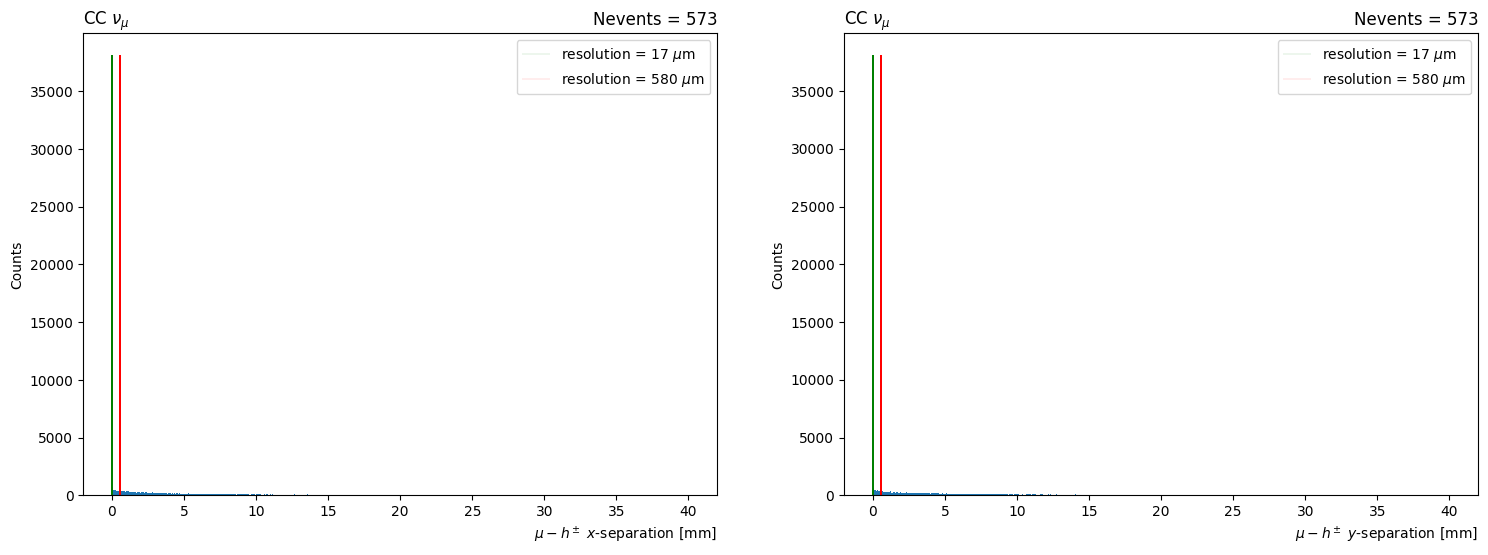

In [50]:
fig, ax = plt.subplots(ncols=2, figsize=(18, 6))
ax[0].bar(xbin_centers, xvalues, width=xsep_hist.axes[0].widths)
ax[0].vlines(np.ones_like(xvalues)*17e-3, 0, np.amax(xvalues), label=r"resolution = 17 $\mu$m", color='green', linewidth=0.1)
ax[0].vlines(np.ones_like(xvalues)*580e-3, 0, np.amax(xvalues), label=r"resolution = 580 $\mu$m", color='red', linewidth=0.1)
ax[0].set_xlabel(r'$\mu - h^\pm$ $x$-separation [mm]', loc="right")
ax[0].set_ylabel('Counts')
ax[0].set_title(r'CC $\nu_\mu$', loc='left')
ax[0].set_title(f'Nevents = {len(muon_cc_event_numbers)}', loc='right')
# ax[0].set_xlim((0, 600e-3))
ax[0].legend()


ax[1].bar(ybin_centers, yvalues, width=ysep_hist.axes[0].widths)
ax[1].vlines(np.ones_like(yvalues)*17e-3, 0, np.amax(yvalues), label=r"resolution = 17 $\mu$m", color='green', linewidth=0.1)
ax[1].vlines(np.ones_like(yvalues)*580e-3, 0, np.amax(yvalues), label=r"resolution = 580 $\mu$m", color='red', linewidth=0.1)
ax[1].set_xlabel(r'$\mu - h^\pm$ $y$-separation [mm]', loc="right")
ax[1].set_ylabel('Counts')
ax[1].set_title(r'CC $\nu_\mu$', loc='left')
ax[1].set_title(f'Nevents = {len(muon_cc_event_numbers)}', loc='right')
# ax[1].set_xlim((0, 600e-3))
ax[1].legend()

plt.savefig("ccMuons_xySeps_allHits.pdf")
plt.show()


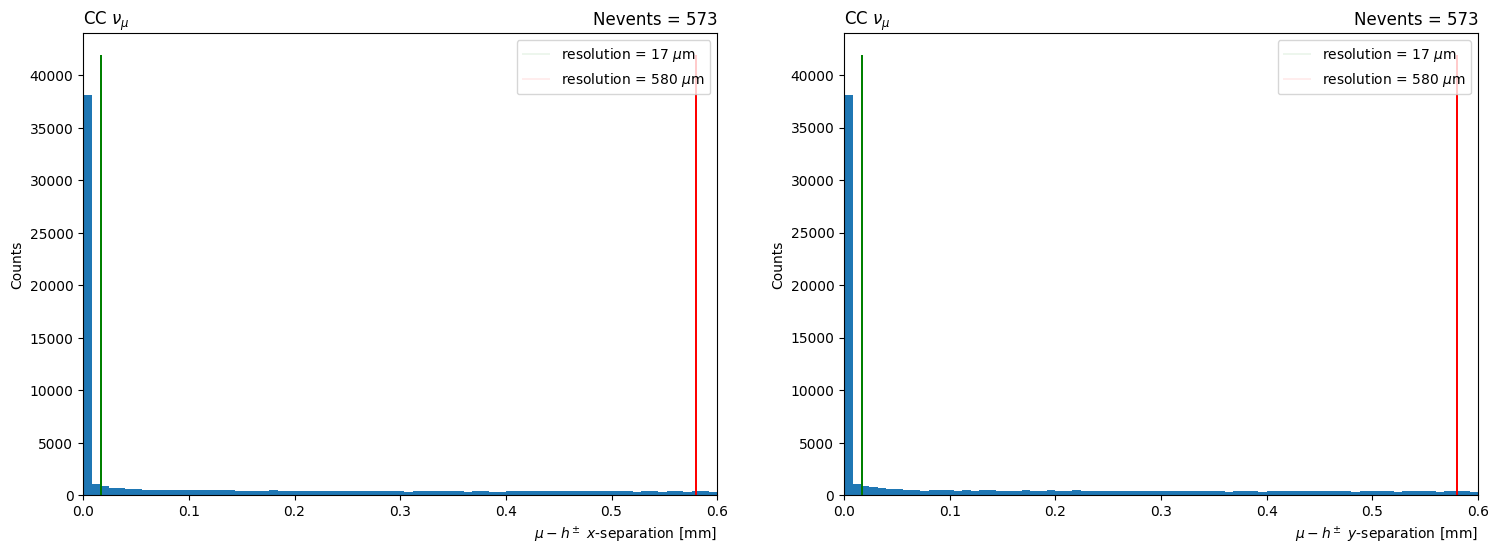

In [51]:
fig, ax = plt.subplots(ncols=2, figsize=(18, 6))
ax[0].bar(xbin_centers, xvalues, width=xsep_hist.axes[0].widths)
ax[0].vlines(np.ones_like(xvalues)*17e-3, 0, np.amax(xvalues)*1.1, label=r"resolution = 17 $\mu$m", color='green', linewidth=0.1)
ax[0].vlines(np.ones_like(xvalues)*580e-3, 0, np.amax(xvalues)*1.1, label=r"resolution = 580 $\mu$m", color='red', linewidth=0.1)
ax[0].set_xlabel(r'$\mu - h^\pm$ $x$-separation [mm]', loc="right")
ax[0].set_ylabel('Counts')
ax[0].set_title(r'CC $\nu_\mu$', loc='left')
ax[0].set_title(f'Nevents = {len(muon_cc_event_numbers)}', loc='right')
ax[0].set_xlim((0, 600e-3))
ax[0].legend()


ax[1].bar(ybin_centers, yvalues, width=ysep_hist.axes[0].widths)
ax[1].vlines(np.ones_like(yvalues)*17e-3, 0, np.amax(yvalues)*1.1, label=r"resolution = 17 $\mu$m", color='green', linewidth=0.1)
ax[1].vlines(np.ones_like(yvalues)*580e-3, 0, np.amax(yvalues)*1.1, label=r"resolution = 580 $\mu$m", color='red', linewidth=0.1)
ax[1].set_xlabel(r'$\mu - h^\pm$ $y$-separation [mm]', loc="right")
ax[1].set_ylabel('Counts')
ax[1].set_title(r'CC $\nu_\mu$', loc='left')
ax[1].set_title(f'Nevents = {len(muon_cc_event_numbers)}', loc='right')
ax[1].set_xlim((0, 600e-3))
ax[1].legend()

plt.savefig("ccMuons_xySeps_allHits_inResoRange.pdf")
plt.show()


In [28]:
axis = bh.axis.Regular(5000, 0, 40)
xsep_hist = bh.Histogram(axis)
ysep_hist = bh.Histogram(axis)

nhits_x_lq_17mum = 0
nhits_y_lq_17mum = 0

nhits_x_lq_580mum = 0
nhits_y_lq_580mum = 0

for event_number in tqdm(muon_cc_event_numbers): #TODO: Can I do this without an event loop?
    
    layer_counter = 0
    for s, station in enumerate(hits):    
        kinematics = station.arrays(station.keys(), library="ak", cut=f"(fEvent == {event_number}) & (z > 0)")
        
        if not 13 in np.abs(kinematics['pdgc']): continue
        
        muons = kinematics[np.where(np.abs(kinematics['pdgc']) == 13)]
        electrons = kinematics[np.where(np.abs(kinematics['pdgc']) == 11)]
        charged_hadrons = kinematics[np.where(np.abs(kinematics['pdgc']) > 37)]
        charged_hadrons = kinematics[np.where(get_charge_from_pdgc(kinematics['pdgc']) != 0)]
        
        if len(muons) != 1: continue
        
        layer_counter += 1
        
        hadron_muon_delta_x = np.abs(charged_hadrons["x"] - muons["x"])
        hadron_muon_delta_y = np.abs(charged_hadrons["y"] - muons["y"])
        
        xsep_hist.fill(hadron_muon_delta_x)
        ysep_hist.fill(hadron_muon_delta_y)
        
        if layer_counter > 10:
            break


100%|██████████| 573/573 [08:42<00:00,  1.10it/s]


In [29]:
# Convert histogram to values for plotting
xbin_edges = xsep_hist.axes[0].edges
xbin_centers = (xbin_edges[:-1] + xbin_edges[1:]) / 2
xvalues = xsep_hist.view()

ybin_edges = ysep_hist.axes[0].edges
ybin_centers = (ybin_edges[:-1] + ybin_edges[1:]) / 2
yvalues = ysep_hist.view()

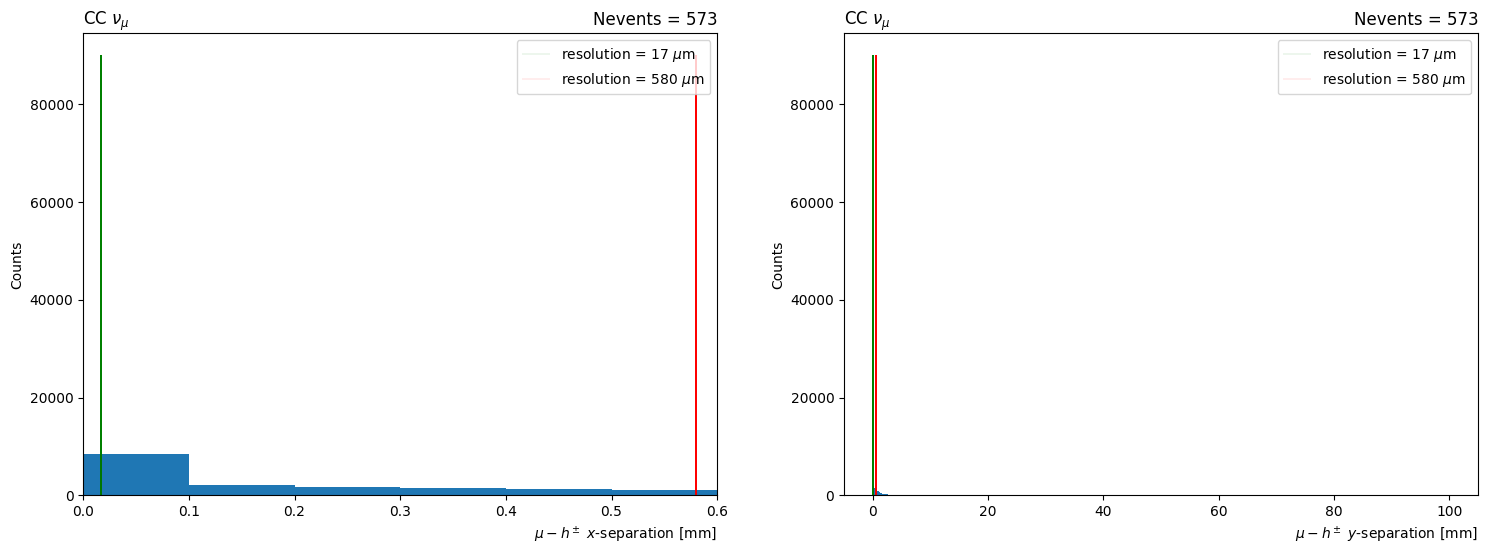

In [31]:
fig, ax = plt.subplots(ncols=2, figsize=(18, 6))
ax[0].bar(xbin_centers, xvalues, width=xsep_hist.axes[0].widths)
ax[0].vlines(np.ones_like(xvalues)*17e-3, 0, np.amax(xvalues), label=r"resolution = 17 $\mu$m", color='green', linewidth=0.1)
ax[0].vlines(np.ones_like(xvalues)*580e-3, 0, np.amax(xvalues), label=r"resolution = 580 $\mu$m", color='red', linewidth=0.1)
ax[0].set_xlabel(r'$\mu - h^\pm$ $x$-separation [mm]', loc="right")
ax[0].set_ylabel('Counts')
ax[0].set_title(r'CC $\nu_\mu$', loc='left')
ax[0].set_title(f'Nevents = {len(muon_cc_event_numbers)}', loc='right')
# ax[0].set_xlim((0, 600e-3))
ax[0].legend()


ax[1].bar(ybin_centers, yvalues, width=ysep_hist.axes[0].widths)
ax[1].vlines(np.ones_like(yvalues)*17e-3, 0, np.amax(yvalues), label=r"resolution = 17 $\mu$m", color='green', linewidth=0.1)
ax[1].vlines(np.ones_like(yvalues)*580e-3, 0, np.amax(yvalues), label=r"resolution = 580 $\mu$m", color='red', linewidth=0.1)
ax[1].set_xlabel(r'$\mu - h^\pm$ $y$-separation [mm]', loc="right")
ax[1].set_ylabel('Counts')
ax[1].set_title(r'CC $\nu_\mu$', loc='left')
ax[1].set_title(f'Nevents = {len(muon_cc_event_numbers)}', loc='right')
# ax[1].set_xlim((0, 600e-3))
ax[1].legend()

plt.savefig("ccMuons_xySeps_allHits.pdf")
plt.show()
